In [1]:

lang = 'en'
fs = 16000 #@param {type:"integer"}
tag = 'Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave' #@param ["Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave", "kamo-naoyuki/librispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_bpe5000_scheduler_confwarmup_steps40000_optim_conflr0.0025_sp_valid.acc.ave"] {type:"string"}


In [2]:
# Initialize models
import time
import torch
import string
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.asr_inference import Speech2Text

d = ModelDownloader()
# It may takes a while to download and build models
speech2text = Speech2Text(
    **d.download_and_unpack(tag),
    device="cuda",
    minlenratio=0.0,
    maxlenratio=0.0,
    ctc_weight=0.3,
    beam_size=10,
    batch_size=0,
    nbest=1
)

def text_normalizer(text):
    text = text.upper()
    return text.translate(str.maketrans('', '', string.punctuation))

In [3]:
# Create Librispeech input. Download and unzip test-clean set from https://www.openslr.org/12 first.
from pathlib import Path
import csv

lang = 'en'
sr = '16000'
with open('LibriSpeech/test_clean.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames={'id', 'lang', 'path', 'sr', 'text'})
    writer.writeheader()
    
    speech_id = 0
    root = Path('LibriSpeech/test-clean')
    for asr_dir in root.iterdir():
        for sub_dir in asr_dir.iterdir():
            file = list(sub_dir.glob('*.txt'))[0]
            with file.open() as f:
                for line in f.readlines():
                    file_name, text = line.split(' ', 1)
                    path = (sub_dir / f'{file_name}.flac')
                    
                    writer.writerow({'id': speech_id, 'lang': lang, 'path': str(path), 'sr': sr, 'text': text.strip()})
                    speech_id += 1


Input Speech: LibriSpeech/test-clean/4446/2273/4446-2273-0000.flac


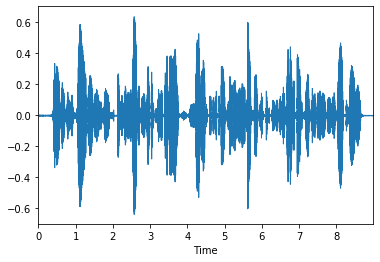

Reference text: HILDA WAS VERY NICE TO HIM AND HE SAT ON THE EDGE OF HIS CHAIR FLUSHED WITH HIS CONVERSATIONAL EFFORTS AND MOVING HIS CHIN ABOUT NERVOUSLY OVER HIS HIGH COLLAR
ASR hypothesis: HILTON WAS VERY NICE TO HIM AND HES SAT ON THE EDGE OF HIS CHAIR FLESHED WITH HIS CONVERSATIONAL EFFORTS AND MOVING HIS CHIN ABOUT NERVOUSLY OVER HIS HIGH CALLER
**************************************************
Input Speech: LibriSpeech/test-clean/4446/2273/4446-2273-0001.flac


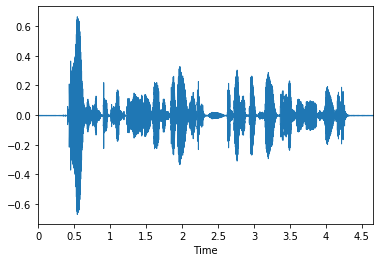

Reference text: THEY ASKED HIM TO COME TO SEE THEM IN CHELSEA AND THEY SPOKE VERY TENDERLY OF HILDA
ASR hypothesis: THEY ASKED THEM TO COME UP TO SEE THEM IN CHELSEA AND THEYVE SPOKEN VERY HEAVILY AT HILTON
**************************************************
Input Speech: LibriSpeech/test-clean/4446/2273/4446-2273-0002.flac


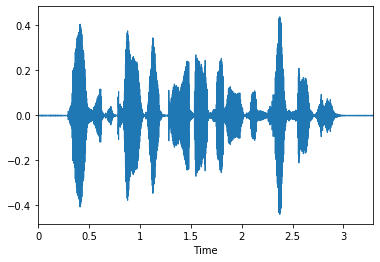

Reference text: LAMB WOULDNT CARE A GREAT DEAL ABOUT MANY OF THEM I FANCY
ASR hypothesis: LAM WOULDNT CARE A GREAT DEAL ABOUT MANY OF THEM I FANCI
**************************************************


In [5]:
# test on few samples 
import pandas as pd
import soundfile
import librosa.display
from IPython.display import display, Audio
import matplotlib.pyplot as plt

egs = pd.read_csv("LibriSpeech/test_clean.csv")
for index, row in egs.iterrows():
    if index >= 3:
        break
    if row["lang"] == lang or lang == "multilingual":
        speech, rate = soundfile.read(row["path"])
        assert fs == int(row["sr"])
        nbests = speech2text(speech)

        text, *_ = nbests[0]
        print(f"Input Speech: {row['path']}")
        # let us listen to samples
        display(Audio(speech, rate=rate))
        librosa.display.waveplot(speech, sr=rate)
        plt.show()
        print(f"Reference text: {text_normalizer(row['text'])}")
        print(f"ASR hypothesis: {text_normalizer(text)}")
        print("*" * 50)

In [ ]:
# inference on whole dataset
refs, hyps = [], []
egs = pd.read_csv("LibriSpeech/test_clean.csv")
for index, row in egs.iterrows():
    speech, rate = soundfile.read(row["path"])
    assert fs == int(row["sr"])
    nbests = speech2text(speech)

    text, *_ = nbests[0]

    refs.append(text_normalizer(row['text']))
    hyps.append({text_normalizer(text)})


In [12]:
import numpy as np
model = speech2text.asr_model
num_params = sum([np.prod(p.size()) for p in model.parameters()])
print(num_params)

116146960


In [ ]:
from timeit import default_timer as timer

start = timer()
# ...
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282
